Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Batch Predictions for an Image Classification model trained using AutoML
In this notebook, we go over how you can use [Azure Machine Learning service pipelines](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-pipeline-batch-scoring-classification) to run a batch scoring image classification job. 

### Prerequisites

> * Train an image classification model using AutoML for Images. Refer [this](https://github.com/swatig007/automlForImages/blob/main/MultiClass/AutoMLImage_MultiClass_SampleNotebook.ipynb) to know how to train an image classification model with AutoML.

You will perform the following tasks:

> * Register a Model we trained using AutoML for Image Classification.
> * Create the Inference Dataset.
> * Provision compute targets and create a Batch Scoring script.
> * Use ParallelRunStep to do batch scoring.
> * Build, run, and publish a pipeline.
> * Enable a REST endpoint for the pipeline.

## Setup
Batch Inference package can be installed through the following pip command.

In [ ]:
pip install --upgrade "azureml-pipeline-steps"

### Licensing Information - 
This preview software is made available to you on the condition that you agree to
[your agreement][1] governing your use of Azure, and to the Supplemental Terms of Use for Microsoft Azure Previews[2], which supplement your agreement governing your use of Azure.
If you do not have an existing agreement governing your use of Azure, you agree that 
your agreement governing use of Azure is the [Microsoft Online Subscription Agreement][3]
(which incorporates the [Online Services Terms][4]).
By using the software you agree to these terms. This software may collect data
that is transmitted to Microsoft. Please see the [Microsoft Privacy Statement][5]
to learn more about how Microsoft processes personal data.

[1]: https://azure.microsoft.com/en-us/support/legal/
[2]: https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/
[3]: https://azure.microsoft.com/en-us/support/legal/subscription-agreement/
[4]: http://www.microsoftvolumelicensing.com/DocumentSearch.aspx?Mode=3&DocumentTypeId=46
[5]: http://go.microsoft.com/fwlink/?LinkId=248681 


## Workspace setup

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [1]:
## specify workspace parameters
#subscription_id='<my-subscription-id>'   
#resource_group='<my-resource-group>'   
#workspace_name='<my-workspace-name>'

from azureml.core.workspace import Workspace

subscription_id='601f4351-33bb-4d76-96ca-886940409b3d'   
resource_group='amlwestus'   
workspace_name='amlwestus'

ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group, 
                      exist_ok=True)

## Workspace default datastore is used to store inference input images and outputs


In [2]:
from azureml.core.datastore import Datastore

def_data_store = ws.get_default_datastore()

## Create data objects

When building pipelines, `Dataset` objects are used for reading data from workspace datastores, and `PipelineData`  objects are used for transferring intermediate data between pipeline steps.

This batch scoring example only uses one pipeline step, but in use-cases with multiple steps, the typical flow will include:

1. Using `Dataset` objects as **inputs** to fetch raw data, performing some transformations, then **outputs** a `PipelineData` object.
1. Use the previous step's `PipelineData` **output object** as an *input object*, repeated for subsequent steps.

For this scenario you create `Dataset` objects corresponding to the datastore directories for the input images. You also create a `PipelineData` object for the batch scoring output data.

In [3]:
from azureml.core.dataset import Dataset
from azureml.pipeline.core import PipelineData

input_images = Dataset.File.from_files((def_data_store, "fridgeObjects/**/*.jpg"))

output_dir = PipelineData(name="scores", datastore=def_data_store)

Next, we need to register the datasets with the workspace.

In [4]:
input_images = input_images.register(workspace=ws, name="fridgeObjects_scoring_images", create_new_version =  True)

## Retrieve the environmnent and metrics from the training run

In [5]:
from azureml.core.experiment import Experiment
from azureml.core import Run

experiment_name = 'automl-image-batchscoring' 
training_run_id = "AutoML_a7cfdaab-cd40-4584-9d29-3812ac9207a1_HD_2"
exp = Experiment(ws, experiment_name)
training_run = Run(exp, training_run_id)

# The below will give only the requested metric
metrics = training_run.get_metrics('accuracy')
best_metric = max(metrics['accuracy'])
print('best_metric:', best_metric)

# Retrieve the training environment
env = training_run.get_environment()
print(env)

best_metric: 100.0
Environment(Name: AutoML-AzureML-AutoML-DNN-Vision-GPU,
Version: Autosave_2021-04-21T04:54:00Z_3c11cdea)


### Register model with metric and environment tags

Now you register the model to your workspace, which allows you to easily retrieve it in the pipeline process. In the `register()` static function, the `model_name` parameter is the key you use to locate your model throughout the SDK.
Tag the model with the metrics and the environment used to train the model.

In [6]:
from azureml.core.model import Model

tags = dict()
tags['accuracy'] = best_metric
tags['env_name'] = env.name
tags['env_version'] = env.version

model_name = 'fridgeObjectsClassifier'
model = training_run.register_model(model_name=model_name, model_path='train_artifacts', tags=tags)

In [7]:
# List the models from the workspace
models = Model.list(ws, name=model_name,latest=True)
print(model.name)
print(model.tags)

fridgeObjectsClassifier
{'accuracy': '100.0', 'env_name': 'AutoML-AzureML-AutoML-DNN-Vision-GPU', 'env_version': 'Autosave_2021-04-21T04:54:00Z_3c11cdea'}


## Create and attach remote compute target

Azure Machine Learning service pipelines cannot be run locally, and only run on cloud resources. Remote compute targets are reusable virtual compute environments where you run experiments and work-flows. Run the following code to create a GPU-enabled [`AmlCompute`](https://docs.microsoft.com/python/api/azureml-core/azureml.core.compute.amlcompute.amlcompute?view=azure-ml-py) target, and attach it to your workspace. See the [conceptual article](https://docs.microsoft.com/azure/machine-learning/service/concept-compute-target) for more information on compute targets.

In [8]:
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.exceptions import ComputeTargetException
compute_name = "nc6cluster"

# checks to see if compute target already exists in workspace, else create it
try:
    compute_target = ComputeTarget(workspace=ws, name=compute_name)
except ComputeTargetException:
    config = AmlCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                   vm_priority="dedicated", 
                                                   min_nodes=0, 
                                                   max_nodes=1)

    compute_target = ComputeTarget.create(workspace=ws, name=compute_name, provisioning_configuration=config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

## Write a scoring script

To do the scoring, you create a batch scoring script `batch_scoring.py`, and write it to the current directory. The script takes a minibatch of input images, applies the classification model, and outputs the predictions to a results file.

The script `batch_scoring.py` takes the following parameters, which get passed from the `ParallelRunStep` that you create later:

- `--model_name`: the name of the model being used

The pipelines infrastructure uses the `ArgumentParser` class to pass parameters into pipeline steps. For example, in the code below the first argument `--model_name` is given the property identifier `model_name`. In the `main()` function, this property is accessed using `Model.get_model_path(args.model_name)`.

The pipeline in this tutorial only has one step and writes the output to a file, but for multi-step pipelines, you also use `ArgumentParser` to define a directory to write output data for input to subsequent steps. See the [notebook](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/nyc-taxi-data-regression-model-building/nyc-taxi-data-regression-model-building.ipynb) for an example of passing data between multiple pipeline steps using the `ArgumentParser` design pattern.

## Build and run the pipeline

### Create the parallel-run configuration to wrap the inference script
Create the pipeline step using the script, environment configuration, and parameters. Specify the compute target you already attached to your workspace as the target of execution of the script. We will use PythonScriptStep to create the pipeline step.

Refer this [site](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/machine-learning-pipelines/parallel-run) for more details on ParallelRunStep of Azure Machine Learning Pipelines.

In [9]:
from azureml.pipeline.steps import ParallelRunConfig

parallel_run_config = ParallelRunConfig(
    environment=env,
    entry_script="batch_scoring.py",
    source_directory="scripts",
    output_action="append_row",
    append_row_file_name="parallel_run_step.txt",
    mini_batch_size="20",
    error_threshold=1,
    compute_target=compute_target,
    process_count_per_node=2,
    node_count=1
)

### Create the pipeline step

A pipeline step is an object that encapsulates everything you need for running a pipeline including:

* environment and dependency settings
* the compute resource to run the pipeline on
* input and output data, and any custom parameters
* reference to a script to run during the step

There are multiple classes that inherit from the parent class [`PipelineStep`](https://docs.microsoft.com/python/api/azureml-pipeline-steps/azureml.pipeline.steps.parallelrunstep?view=azure-ml-py) to assist with building a step using certain frameworks and stacks. In this example, you use the [`ParallelRunStep`](https://docs.microsoft.com/en-us/python/api/azureml-contrib-pipeline-steps/azureml.contrib.pipeline.steps.parallelrunstep?view=azure-ml-py) class to define your step logic using a scoring script. [`ParallelRunStep`] does executes the script in a distributed fashion.

An object reference in the `outputs` array becomes available as an **input** for a subsequent pipeline step, for scenarios where there is more than one step.

In [10]:
from azureml.pipeline.steps import ParallelRunStep
from datetime import datetime

parallel_step_name = "batchscoring-" + datetime.now().strftime("%Y%m%d%H%M")

batch_score_step = ParallelRunStep(
    name=parallel_step_name,
    inputs=[input_images.as_named_input("input_images")],
    output=output_dir,
    arguments=["--model_name", model_name],
    parallel_run_config=parallel_run_config,
    allow_reuse=False
)

WARNING - 'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


For a list of all classes for different step types, see the [steps package](https://docs.microsoft.com/python/api/azureml-pipeline-steps/azureml.pipeline.steps?view=azure-ml-py).

### Run the pipeline

Now you run the pipeline. First create a `Pipeline` object with your workspace reference and the pipeline step you created. The `steps` parameter is an array of steps, and in this case there is only one step for batch scoring. To build pipelines with multiple steps, you place the steps in order in this array.

Next use the `Experiment.submit()` function to submit the pipeline for execution. You also specify the custom parameter `param_batch_size`. The `wait_for_completion` function will output logs during the pipeline build process, which allows you to see current progress.

Note: The first pipeline run takes roughly **15 minutes**, as all dependencies must be downloaded, a Docker image is created, and the Python environment is provisioned/created. Running it again takes significantly less time as those resources are reused. However, total run time depends on the workload of your scripts and processes running in each pipeline step.

In [11]:
from azureml.core import Experiment
from azureml.pipeline.core import Pipeline

pipeline = Pipeline(workspace=ws, steps=[batch_score_step])
pipeline_run = Experiment(ws, "batch_scoring_automl_image").submit(pipeline)

Created step batchscoring-202104231641 [93415cc3][f1627455-09d9-480e-9bbf-187596af6e8a], (This step will run and generate new outputs)
Submitted PipelineRun 65b74f39-ec71-470a-aaae-683282b75534
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/65b74f39-ec71-470a-aaae-683282b75534?wsid=/subscriptions/601f4351-33bb-4d76-96ca-886940409b3d/resourcegroups/amlwestus/workspaces/amlwestus&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


In [12]:
# This will output information of the pipeline run, including the link to the details page of portal.
pipeline_run

Experiment,Id,Type,Status,Details Page,Docs Page
batch_scoring_automl_image,65b74f39-ec71-470a-aaae-683282b75534,azureml.PipelineRun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
# Wait the run for completion and show output log to console
pipeline_run.wait_for_completion(show_output=True)

### Download and review output

Run the following code to download the output file created from the `batch_scoring.py` script, then explore the scoring results.

In [14]:
import pandas as pd
import tempfile
import os

batch_run = pipeline_run.find_step_run(batch_score_step.name)[0]
batch_output = batch_run.get_output_data(output_dir.name)

target_dir = tempfile.mkdtemp()
batch_output.download(local_path=target_dir)
result_file = os.path.join(target_dir, batch_output.path_on_datastore, parallel_run_config.append_row_file_name)
result_file

# Print the first five lines of the output
with open(result_file) as f:
    for x in range(5):
        print(next(f))

{"filename": "/mnt/batch/tasks/shared/LS_root/jobs/amlwestus/azureml/4b9aeccb-b983-4b71-8267-88a7e0207dc6/wd/tmpv78k2q78/carton/53.jpg", "probs": [5.682211849489249e-06, 0.999968409538269, 1.857374081737362e-05, 7.335314421652583e-06], "labels": ["can", "carton", "milk_bottle", "water_bottle"]}

{"filename": "/mnt/batch/tasks/shared/LS_root/jobs/amlwestus/azureml/4b9aeccb-b983-4b71-8267-88a7e0207dc6/wd/tmpv78k2q78/carton/54.jpg", "probs": [0.0006190850399434566, 0.9978424310684204, 0.0008537590620107949, 0.0006847319891676307], "labels": ["can", "carton", "milk_bottle", "water_bottle"]}

{"filename": "/mnt/batch/tasks/shared/LS_root/jobs/amlwestus/azureml/4b9aeccb-b983-4b71-8267-88a7e0207dc6/wd/tmpv78k2q78/carton/55.jpg", "probs": [1.5082821846590377e-05, 0.9999021291732788, 4.266345422365703e-05, 4.017941319034435e-05], "labels": ["can", "carton", "milk_bottle", "water_bottle"]}

{"filename": "/mnt/batch/tasks/shared/LS_root/jobs/amlwestus/azureml/4b9aeccb-b983-4b71-8267-88a7e0207dc6/

## Choose a random file for visualization

In [15]:
import random
import json

with open(result_file, 'r') as f:
    contents = f.readlines()

rand_file = contents[random.randrange(len(contents))]
prediction = json.loads(rand_file)
print(prediction['filename'])
print(prediction['probs'])
print(prediction['labels'])

/mnt/batch/tasks/shared/LS_root/jobs/amlwestus/azureml/4b9aeccb-b983-4b71-8267-88a7e0207dc6/wd/tmpv78k2q78/water_bottle/103.jpg
[9.378569302498363e-06, 5.921440333622741e-06, 0.0004887780523858964, 0.9994958639144897]
['can', 'carton', 'milk_bottle', 'water_bottle']


In [16]:
# Download the image file from the datastore
path = 'fridgeObjects'+'/'+prediction['filename'].split('/')[-2]+'/'+prediction['filename'].split('/')[-1]
path_on_datastore = def_data_store.path(path)
single_image_ds = Dataset.File.from_files(path=path_on_datastore, validate=False)
image = single_image_ds.download()[0]

water_bottle (0.999)


<Figure size 1296x864 with 0 Axes>

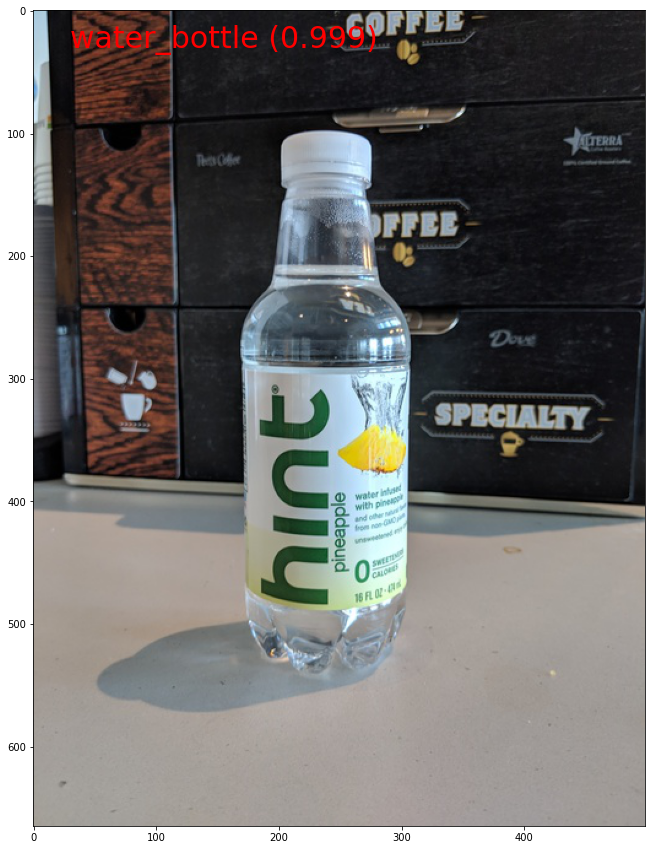

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 3))
print(display_text)

color = 'red'
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

## Publish and run from REST endpoint

Run the following code to publish the pipeline to your workspace. In your workspace in the portal, you can see metadata for the pipeline including run history and durations. You can also run the pipeline manually from the portal.

Additionally, publishing the pipeline enables a REST endpoint to rerun the pipeline from any HTTP library on any platform.

In [ ]:
published_pipeline = pipeline_run.publish_pipeline(
    name="automl-image-batch-scoring", description="Batch scoring using Automl for Image", version="1.0")

published_pipeline

To run the pipeline from the REST endpoint, you first need an OAuth2 Bearer-type authentication header. This example uses interactive authentication for illustration purposes, but for most production scenarios requiring automated or headless authentication, use service principle authentication as [described in this notebook](https://aka.ms/pl-restep-auth).

Service principle authentication involves creating an **App Registration** in **Azure Active Directory**, generating a client secret, and then granting your service principal **role access** to your machine learning workspace. You then use the [`ServicePrincipalAuthentication`](https://docs.microsoft.com/python/api/azureml-core/azureml.core.authentication.serviceprincipalauthentication?view=azure-ml-py) class to manage your auth flow. 

Both `InteractiveLoginAuthentication` and `ServicePrincipalAuthentication` inherit from `AbstractAuthentication`, and in both cases you use the `get_authentication_header()` function in the same way to fetch the header.

In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()

Get the REST url from the `endpoint` property of the published pipeline object. You can also find the REST url in your workspace in the portal. Build an HTTP POST request to the endpoint, specifying your authentication header. Additionally, add a JSON payload object with the experiment name and the batch size parameter. As a reminder, the `process_count_per_node` is passed through to `ParallelRunStep` because you defined it is defined as a `PipelineParameter` object in the step configuration.

Make the request to trigger the run. Access the `Id` key from the response dict to get the value of the run id.

In [ ]:
import requests

rest_endpoint = published_pipeline.endpoint
response = requests.post(rest_endpoint, 
                         headers=auth_header, 
                         json={"ExperimentName": "batch_scoring",
                               "ParameterAssignments": {"process_count_per_node": 2}})

In [ ]:
try:
    response.raise_for_status()
except Exception:    
    raise Exception("Received bad response from the endpoint: {}\n"
                    "Response Code: {}\n"
                    "Headers: {}\n"
                    "Content: {}".format(rest_endpoint, response.status_code, response.headers, response.content))

run_id = response.json().get('Id')
print('Submitted pipeline run: ', run_id)

Use the run id to monitor the status of the new run. This will take another 10-15 min to run and will look similar to the previous pipeline run, so if you don't need to see another pipeline run, you can skip watching the full output.

In [ ]:
from azureml.pipeline.core.run import PipelineRun

published_pipeline_run = PipelineRun(ws.experiments["batch_scoring"], run_id)
published_pipeline_run